In [1]:
# !pip install opencv-python

In [2]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from pathlib import Path

from tqdm import tqdm
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import random
import gc
import cv2

import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
# tf.autograph.set_verbosity(2)
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-c0u_u90e because the default path (/home/nlapid/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Preparing the Dataset and Setting Parameters

In [3]:
seed = 143
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

In [4]:
data_dir = './raw/'
save_dir = './savefiles/'
size = 64
epochs = 30
val_split = 0.25

batch_size = 32

data_path = Path(data_dir)
images = sorted(list(map(str, list(data_path.glob("*/*.jpg")))))
labels = set([img.split(os.path.sep)[-2] for img in images])
num_labels = len(labels)

steps_per_epoch = len(images) * (1 - val_split) / batch_size
validation_steps = len(images) * val_split / batch_size

print("Number of images found: ", len(images))
print("Number of labels found: ", num_labels)
print("Labels:", sorted(labels))

Number of images found:  38398
Number of labels found:  19
Labels:
['a', 'ba', 'dara', 'ei', 'ga', 'ha', 'ka', 'kuw', 'la', 'ma', 'na', 'nga', 'ou', 'pa', 'sa', 'ta', 'tul', 'wa', 'ya']


In [5]:
# !ls raw

In [6]:
# Check dimensions of a sample image

# img = cv2.imread(data_dir + 'a/a_00553_file087.jpg')
# dimensions = img.shape
# dimensions

In [7]:
# Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=val_split,
                                   preprocessing_function=None,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.3],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.7,
                                   horizontal_flip=False,
                                   vertical_flip=False,)

val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=val_split)


# Load data and turn into batches
train_data = train_datagen.flow_from_directory(data_dir,
                                               subset="training",
                                               target_size=(size, size),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               seed=seed)

val_data = val_datagen.flow_from_directory(data_dir,
                                           subset="validation",
                                           target_size=(size, size),
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           seed=seed)

Found 28806 images belonging to 19 classes.
Found 9592 images belonging to 19 classes.


In [28]:
# For Keras Models (VGG16, Inception)

keras_train_datagen = ImageDataGenerator(validation_split=val_split,
                                   preprocessing_function=None,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.3],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.7,
                                   horizontal_flip=False,
                                   vertical_flip=False,)

keras_val_datagen = ImageDataGenerator(validation_split=val_split)


# Load data and turn into batches
keras_train_data = keras_train_datagen.flow_from_directory(data_dir,
                                               subset="training",
                                               target_size=(size, size),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               seed=seed)

keras_val_data = keras_val_datagen.flow_from_directory(data_dir,
                                           subset="validation",
                                           target_size=(size, size),
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           seed=seed)

Found 28806 images belonging to 19 classes.
Found 9592 images belonging to 19 classes.


In [8]:
len(set(train_data.labels))

19

## Models

### CNN

In [63]:
tf.keras.backend.clear_session()
gc.collect()

16849

In [64]:
base_cnn = models.Sequential()

base_cnn.add(layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same',
                 input_shape=(size, size, 3)))
base_cnn.add(layers.BatchNormalization(axis=3))
base_cnn.add(layers.Activation('relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

base_cnn.add(layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same',
                        activation='relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(3, 3)))

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(32, activation="relu"))
base_cnn.add(layers.Dropout(0.6))

base_cnn.add(layers.Dense(num_labels, activation='softmax'))
base_cnn.summary()


base_cnn.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 4)         112       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 4)         16        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

In [65]:
%%time

filepath_cnn = save_dir + "/base_cnn_wts.hdf5"
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=2, min_lr=0.00001, verbose=1)
earlystop_cnn = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


base_cnn_history = base_cnn.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=val_data,
    callbacks=[checkpoint_cnn, reduce_lr_cnn, earlystop_cnn]
)

Epoch 1/30
899/899 [==============================] - 117s 130ms/step - loss: 2.6534 - accuracy: 0.1702 - val_loss: 1.4708 - val_accuracy: 0.6272

Epoch 00001: val_accuracy improved from -inf to 0.62719, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 2/30
899/899 [==============================] - 117s 130ms/step - loss: 2.1704 - accuracy: 0.3105 - val_loss: 1.0643 - val_accuracy: 0.7681

Epoch 00002: val_accuracy improved from 0.62719 to 0.76814, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 3/30
899/899 [==============================] - 117s 130ms/step - loss: 1.9710 - accuracy: 0.3675 - val_loss: 0.8629 - val_accuracy: 0.7809

Epoch 00003: val_accuracy improved from 0.76814 to 0.78086, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 4/30
899/899 [==============================] - 113s 126ms/step - loss: 1.8641 - accuracy: 0.3997 - val_loss: 0.8034 - val_accuracy: 0.7837

Epoch 00004: val_accuracy improved from 0.78086 to 0.78367, saving model to ./savefiles/base_cnn_

In [66]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

In [67]:
base_cnn.load_weights(filepath_cnn)

base_cnn.save(save_dir + '/base_cnn.h5')

import pickle
with open(save_dir + '/base_cnn_hist.pickle', 'wb') as handle:
    pickle.dump(base_cnn_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

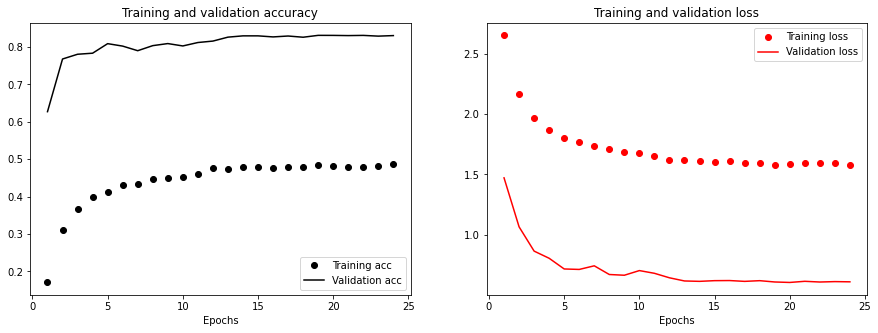

In [68]:
plot_results(base_cnn_history)

### VGG16

In [51]:
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16

vgg16 = tf.keras.applications.VGG16(weights=None,
                  include_top=False)

model_vgg16 = models.Sequential()
model_vgg16.add(layers.Lambda(preprocess_vgg16,
                             input_shape=(size, size, 3)))
model_vgg16.add(vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(num_labels, activation='softmax'))

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_16 (Lambda)           (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 19)                38931     
Total params: 14,753,619
Trainable params: 14,753,619
Non-trainable params: 0
_________________________________________________________________


In [52]:
%%time

filepath_vgg = save_dir + "/base_vgg_wts.hdf5"
checkpoint_vgg = ModelCheckpoint(filepath_vgg, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_vgg = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_vgg = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


vgg_history = model_vgg16.fit(
    keras_train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=keras_val_data,
    callbacks=[checkpoint_vgg, reduce_lr_vgg, earlystop_vgg]
)

Epoch 1/30
899/899 [==============================] - 119s 131ms/step - loss: 0.7331 - accuracy: 0.7733 - val_loss: 0.3934 - val_accuracy: 0.9021

Epoch 00001: val_accuracy improved from -inf to 0.90211, saving model to ./savefiles/base_vgg_wts.hdf5
Epoch 2/30
899/899 [==============================] - 116s 129ms/step - loss: 0.1989 - accuracy: 0.9400 - val_loss: 0.1167 - val_accuracy: 0.9658

Epoch 00002: val_accuracy improved from 0.90211 to 0.96580, saving model to ./savefiles/base_vgg_wts.hdf5
Epoch 3/30
899/899 [==============================] - 140s 156ms/step - loss: 0.1496 - accuracy: 0.9560 - val_loss: 0.1804 - val_accuracy: 0.9441

Epoch 00003: val_accuracy did not improve from 0.96580
Epoch 4/30
899/899 [==============================] - 116s 128ms/step - loss: 0.1197 - accuracy: 0.9649 - val_loss: 0.1340 - val_accuracy: 0.9602

Epoch 00004: val_accuracy did not improve from 0.96580

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/30


In [54]:
model_vgg16.load_weights(filepath_vgg)

model_vgg16.save(save_dir + '/vgg16.h5')

with open(save_dir + '/vgg16_hist.pickle', 'wb') as handle:
    pickle.dump(vgg_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

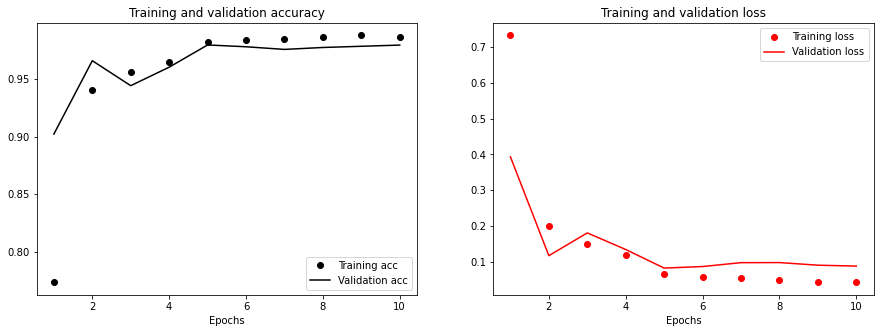

In [56]:
plot_results(vgg_history)

### CoAtNet

In [69]:
import keras_cv_attention_models

In [71]:
coatnet0 = keras_cv_attention_models.coatnet.CoAtNet0(num_classes=0,
                                                      pretrained=None,
                                                      input_shape=(size, size, 3))

model_coat0 = models.Sequential()

model_coat0.add(coatnet0)
model_coat0.add(layers.Flatten())
# model_coat0.add(layers.Dense(32, activation="relu"))
# model_coat0.add(layers.Dropout(0.6))
model_coat0.add(layers.Dense(num_labels, activation='softmax'))

model_coat0.summary()

model_coat0.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 2, 2, 768)         23032698  
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 19)                58387     
Total params: 23,091,085
Trainable params: 23,079,437
Non-trainable params: 11,648
_________________________________________________________________


In [ ]:
%%time

filepath_coat = save_dir + "/base_coat_wts.hdf5"
checkpoint_coat = ModelCheckpoint(filepath_coat, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_coat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
earlystop_coat= EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)


coat_history = model_coat0.fit(
    keras_train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=keras_val_data,
    callbacks=[checkpoint_coat, reduce_lr_coat, earlystop_coat]
)

Epoch 1/30
899/899 [==============================] - 138s 138ms/step - loss: 2.1519 - accuracy: 0.6282 - val_loss: 0.9994 - val_accuracy: 0.8247

Epoch 00001: val_accuracy improved from -inf to 0.82475, saving model to ./savefiles/base_coat_wts.hdf5


/home/msds2022/nlapid/.conda/envs/msds2022-ml3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
899/899 [==============================] - 119s 132ms/step - loss: 0.8063 - accuracy: 0.8394 - val_loss: 0.6910 - val_accuracy: 0.8637

Epoch 00002: val_accuracy improved from 0.82475 to 0.86374, saving model to ./savefiles/base_coat_wts.hdf5
Epoch 3/30
899/899 [==============================] - 117s 130ms/step - loss: 0.6343 - accuracy: 0.8824 - val_loss: 0.6891 - val_accuracy: 0.8864

Epoch 00003: val_accuracy improved from 0.86374 to 0.88636, saving model to ./savefiles/base_coat_wts.hdf5
Epoch 4/30
899/899 [==============================] - 116s 129ms/step - loss: 0.5349 - accuracy: 0.9031 - val_loss: 0.6355 - val_accuracy: 0.8984

Epoch 00004: val_accuracy improved from 0.88636 to 0.89835, saving model to ./savefiles/base_coat_wts.hdf5


In [ ]:
model_coat0.load_weights(filepath_coat)

model_coat0.save(save_dir + '/coat0.h5')

with open(save_dir + '/coat0_hist.pickle', 'wb') as handle:
    pickle.dump(coat_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
plot_results(base_cnn_history)